# Day 2 — Data Cleaning & Feature Engineering

## Remove Duplicates

In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the raw scrapped dataset
df = pd.read_csv(r"C:\Users\user\Nairobi_House_Price_Sprint\data\nairobi_combined_all_property_types_test.csv")

In [3]:
# Display the first few rows
print("Initial CSV Dataset Preview:")
display(df.head())

Initial CSV Dataset Preview:


,Location,Property Type,Bedrooms,Bathrooms,Size (sqm),Amenities,Price (KES),Listing Date
0,Runda,House,5.0,5.0,518.0,"Alarm, BBQ, Backup Generator, Balcony, Borehol...",155040000,21 October 2025
1,Ruiru,House,4.0,5.0,NaN,"Bus Stop, Electric Fence, En Suite, Fibre Inte...",14500000,19 December 2025
2,Lavington,House,4.0,4.0,NaN,"Aircon, Alarm, BBQ, Balcony, Borehole, Bus Sto...",75000000,17 February 2026
3,Syokimau,House,5.0,4.0,NaN,"Alarm, BBQ, Backup Generator, Balcony, Borehol...",35000000,17 February 2026
4,Kikuyu Town,House,NaN,NaN,NaN,NaN,9500000,NaN


In [4]:
# Display the Shape
print("\n The Initial Shape:", df.shape)


 The Initial Shape: (200, 8)


## DATA CLEANING: REMOVING DUPLICATES

In [5]:
df = df.drop_duplicates()

In [6]:
# New Shape
print("After removing duplicates:", df.shape)

After removing duplicates: (200, 8)


## HANDLE MISSING VALUES

In [7]:
# Identify missing values exist per column
print("\nThe Missing Values Before Cleaning:")
print(df.isna().sum())


The Missing Values Before Cleaning:
Location          0
Property Type     0
Bedrooms          4
Bathrooms         4
Size (sqm)       76
Amenities         5
Price (KES)       0
Listing Date      1
dtype: int64


The Strategies for cleaning this dataset are as follows

>- Rows missing the size are Location based filled
>- Fill Bedrooms/Bathrooms with median 
>- Replace missing Amenities with empty string

In [12]:
# Location based imputation
# Standardize location names
df["Location"] = df["Location"].str.strip().str.lower()

# Replace zero size with NaN
df["Size (sqm)"] = df["Size (sqm)"].replace(0, np.nan)

# First fill using location mean
df["Size (sqm)"] = df.groupby("Location")["Size (sqm)"] \
                      .transform(lambda x: x.fillna(x.mean()))

# Then fill remaining with global mean
global_mean = df["Size (sqm)"].mean()
df["Size (sqm)"] = df["Size (sqm)"].fillna(global_mean)

In [13]:
# Fill Bedrooms/Bathroms with the median
df["Bedrooms"] = df["Bedrooms"].fillna(df["Bedrooms"].median())
df["Bathrooms"] = df["Bathrooms"].fillna(df["Bathrooms"].median())

In [14]:
# Replace The missing Amenities With an Empty String
df["Amenities"] = df["Amenities"].fillna("")

In [15]:
# Check The Current Dataset
print("\nMissing Values After Cleaning:")
print(df.isna().sum())


Missing Values After Cleaning:
Location         0
Property Type    0
Bedrooms         0
Bathrooms        0
Size (sqm)       0
Amenities        0
Price (KES)      0
Listing Date     1
dtype: int64


## STANDARDIZE LOCATION NAMES

In [16]:
# Converting of all location names to lowercase and removing leading and trailling spaces
# This will aid in ensuring easy grouping during modelling
df["Location"] = df["Location"].str.lower().str.strip()

In [17]:
print("\nUnique Locations Sample:")
print(df["Location"].unique()[:5])


Unique Locations Sample:
['runda' 'ruiru' 'lavington' 'syokimau' 'kikuyu town']


## CONVERT SIZE UNITS(sqm -> sqft)

In [18]:
# 1 sqm = 10.7639 sqft

df["size_sqft"] = df["Size (sqm)"] * 10.7639

print("The Size Conversion is Complete.")

The Size Conversion is Complete.


## REMOVE EXTREME OUTLIERS

In [19]:
# Using the IQR method to remove extreme price outliers.

Q1 = df["Price (KES)"].quantile(0.25)
Q3 = df["Price (KES)"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[
    (df["Price (KES)"] >= lower_bound) &
    (df["Price (KES)"] <= upper_bound)
]

# Remove top 1% of size values (extremely large mansions)
df = df[df["size_sqft"] < df["size_sqft"].quantile(0.99)]

print("\nAfter Removing Outliers:", df.shape)


After Removing Outliers: (192, 9)


In [24]:
df.head()

,Location,Property Type,Bedrooms,Bathrooms,Size (sqm),Amenities,Price (KES),Listing Date,size_sqft
0,runda,House,5.0,5.0,518.000000,"Alarm, BBQ, Backup Generator, Balcony, Borehol...",155040000,21 October 2025,5575.700200
1,ruiru,House,4.0,5.0,220.314263,"Bus Stop, Electric Fence, En Suite, Fibre Inte...",14500000,19 December 2025,2371.440698
2,lavington,House,4.0,4.0,284.941176,"Aircon, Alarm, BBQ, Balcony, Borehole, Bus Sto...",75000000,17 February 2026,3067.078329
3,syokimau,House,5.0,4.0,160.000000,"Alarm, BBQ, Backup Generator, Balcony, Borehol...",35000000,17 February 2026,1722.224000
4,kikuyu town,House,4.0,4.0,220.314263,,9500000,NaN,2371.440698


## Needed Cleaning Measures

In [27]:
# Remove impossible sizes
df.loc[df["Size (sqm)"] < 20, "Size (sqm)"] = None

# REMOVE INFINITE VALUES
df = df.replace([np.inf, -np.inf], np.nan)

# FILTER ONLY NAIROBI AREAS
# Nairobi County areas only
nairobi_core = [
    "runda", "lavington", "karen", "kileleshwa",
    "kilimani", "riverside", "westlands area",
    "loresho", "kitisuru", "lower kabete",
    "langata", "south b", "south c",
    "donholm", "brookside", "thigiri",
    "nyari", "rosslyn", "muthaiga",
    "parklands", "spring valley"
]

df = df[df["Location"].isin(nairobi_core)]

print("Final Clean Shape:", df.shape)

Final Clean Shape: (155, 9)


In [28]:
df.head()

,Location,Property Type,Bedrooms,Bathrooms,Size (sqm),Amenities,Price (KES),Listing Date,size_sqft
0,runda,House,5.0,5.0,518.000000,"Alarm, BBQ, Backup Generator, Balcony, Borehol...",155040000,21 October 2025,5575.700200
2,lavington,House,4.0,4.0,284.941176,"Aircon, Alarm, BBQ, Balcony, Borehole, Bus Sto...",75000000,17 February 2026,3067.078329
5,lavington,House,5.0,5.0,284.941176,"Alarm, BBQ, Backup Generator, Balcony, Borehol...",100000000,16 February 2026,3067.078329
6,karen,House,5.0,7.0,194.000000,"Balcony, Bus Stop, Fibre Internet, Gated Commu...",130000000,14 February 2026,2088.196600
9,lavington,House,5.0,6.0,284.941176,"Aircon, Alarm, BBQ, Backup Generator, Balcony,...",75000000,13 February 2026,3067.078329


# FEATURE ENGINEERING

In [29]:
# New Feature (Price_Per_Sqft)
# It is an essential real estate indicator that normalizes price relative to property size.

df["price_per_sqft"] = df["Price (KES)"] / df["size_sqft"]

print("Price_per_sqft created.")

Price_per_sqft created.


In [30]:
# New Feature (Amenity_Score)
# This feature counts the number of amenities per property hence more amenities generally increase value.
df["amenity_score"] = df["Amenities"].apply(
    lambda x: len(x.split(",")) if x else 0
)

print("Amenity score feature created.")

Amenity score feature created.


In [31]:
# New Feature (Extracting Month From The Listing Date)

# Convert listing date to datetime format
df["Listing Date"] = pd.to_datetime(df["Listing Date"], errors="coerce")

# Extract month and year for seasonality analysis
df["month"] = df["Listing Date"].dt.month
df["year"] = df["Listing Date"].dt.year

print("The Month and Year features created.")


The Month and Year features created.


# BASIC EDA VISUALS

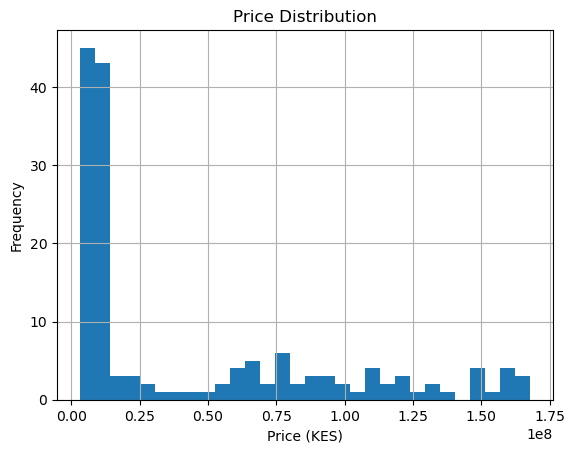

In [32]:
# The Price Distribution
plt.figure()
df["Price (KES)"].hist(bins=30)
plt.title("Price Distribution")
plt.xlabel("Price (KES)")
plt.ylabel("Frequency")
plt.show()

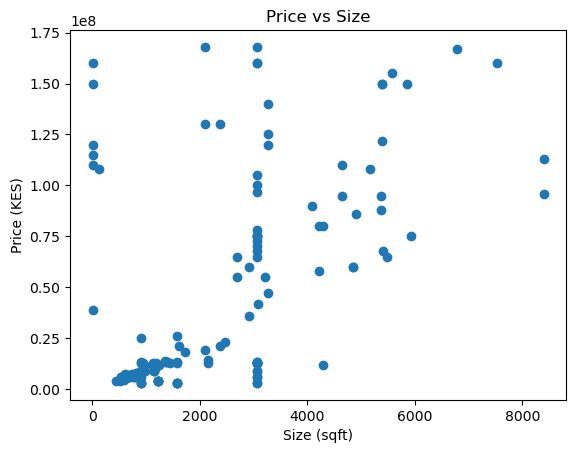

In [33]:
# Price VS Size Comparison
plt.figure()
plt.scatter(df["size_sqft"], df["Price (KES)"])
plt.xlabel("Size (sqft)")
plt.ylabel("Price (KES)")
plt.title("Price vs Size")
plt.show()

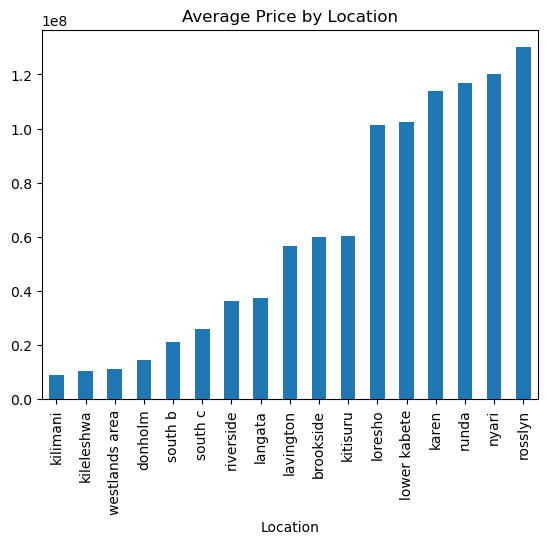

In [34]:
# Average Price By Location
df.groupby("Location")["Price (KES)"] \
  .mean() \
  .sort_values() \
  .plot(kind="bar")

plt.title("Average Price by Location")
plt.show()

## Save The Clean Data

In [35]:
df.to_csv(r"C:\Users\user\Nairobi_House_Price_Sprint\data/clean_listings.csv", index=False)

print("\n✅ Clean dataset saved as clean_listings.csv")
print("Final Shape:", df.shape)


✅ Clean dataset saved as clean_listings.csv
Final Shape: (155, 13)
